<a href="https://colab.research.google.com/github/juanlu29/juanlu29/blob/contaminacionMadrid/preprocesadoDatosContaminacionMadrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Visualizacion de datos de contaminacion de Madrid. Hasta ahora dispongo de 

## Plaza del Cármen, NO2
## Casa de campo, NO2, O3
## Plaza elíptica, Fernández Ladreda,  NO2

Cuatro datasets

El formato es diario partiendo del día 1-1-2010 y las unidades mg/m^3

In [3]:
import pandas as pd
from google.colab import drive
import numpy as np
drive.mount('/content/drive/')

# Exploramos los directorios de drive. Cambiamos directorio a donde estan los datos
%cd /content/drive/My\ Drive/datosContaminacionMadrid

# Lo pasamos a dataframes
est56NO2_df = pd.read_csv('Est56FL_CodPar08NO2_valuesonly.txt', header=0)
est24NO2_df = pd.read_csv('Est24CC_CodPar08NO2_valuesonly.txt', header=0)
est03NO2_df = pd.read_csv('Est03PlC_CodPar08NO2_valuesonly.txt', header=0)
est03O3_df  = pd.read_csv('Est03PlC_CodPar14O3_valuesonly.txt', header=0)




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/datosContaminacionMadrid


Visualizacion interactiva de datos

In [ ]:
import altair as alt
from vega_datasets import data



alt.Chart(est56NO2_df.reset_index()).mark_point().encode(
    x='index',
    y='x',
).interactive()



alt.Chart(...)

In [ ]:
alt.Chart(est03O3_df.reset_index()).mark_line().encode(
    x='index',
    y='x',
).interactive()

alt.Chart(...)

In [ ]:
alt.Chart(est03NO2_df.reset_index()).mark_line().encode(
    x='index',
    y='x',
).interactive()

alt.Chart(...)

3834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10


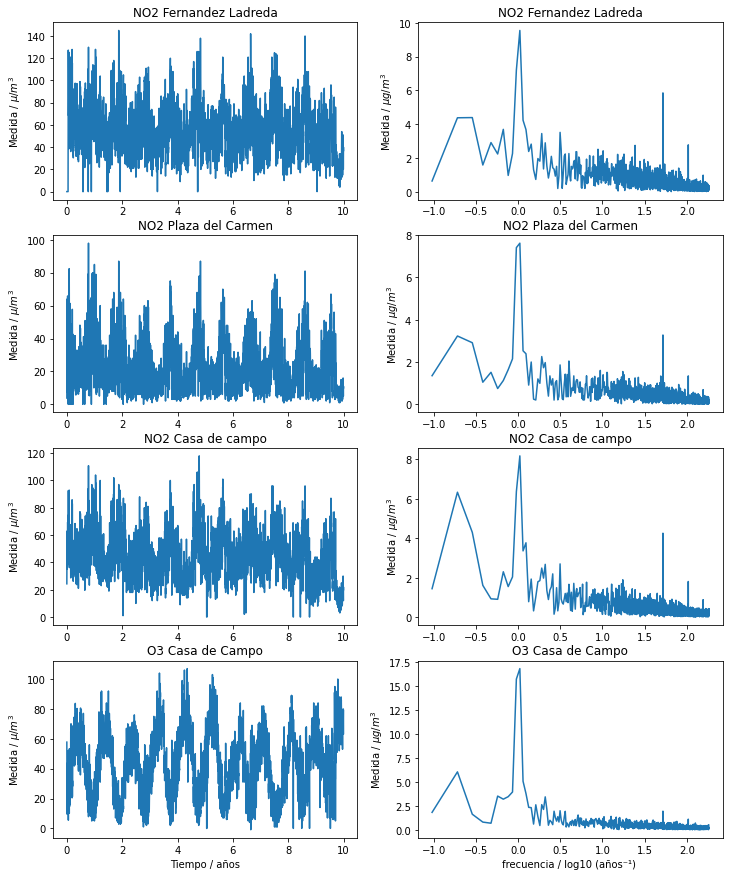

In [42]:
import matplotlib.pyplot as plt
grid_plots_datos, [(axg1,axg5),(axg2,axg6),(axg3,axg7),(axg4,axg8)] = plt.subplots(4,2,figsize=(12,15))
est56NO2_np = est56NO2_df.to_numpy()
est24NO2_np = est24NO2_df.to_numpy()
est03NO2_np = est03NO2_df.to_numpy()
est03O3_np = est03O3_df.to_numpy()
x = np.linspace(0,10,len(est03O3_np))
print(len(est03O3_np))

axg1.plot(x,est56NO2_np)
axg1.set_title("NO2 Fernandez Ladreda")
axg1.set_ylabel("Medida / $\mu / m^{3}$")
axg2.plot(x,est24NO2_np)
axg2.set_title("NO2 Plaza del Carmen")
axg2.set_ylabel("Medida / $\mu / m^{3}$")
axg3.plot(x,est03NO2_np)
axg3.set_title("NO2 Casa de campo")
axg3.set_ylabel("Medida / $\mu / m^{3}$")
axg4.plot(x,est03O3_np)
axg4.set_title("O3 Casa de Campo")
axg4.set_xlabel("Tiempo / años")
axg4.set_ylabel("Medida / $\mu / m^{3}$")

# Frecuencias
frecuencias56, xf56 = frecuenciasInternas(est56NO2_np[:,0],1.)
frecuencias24, xf24 = frecuenciasInternas(est24NO2_np[:,0],1.)
frecuencias03NO2, xf03NO2= frecuenciasInternas(est03NO2_np[:,0],1.)
frecuencias03O3, xf03O3 = frecuenciasInternas(est03O3_np[:,0],1.)

#periodos56 = np.arange(len(frecuencias56))*((2*np.pi)/(len(est56NO2_np)*(1./365)))
periodos56 = np.linspace(0,365./2.,len(frecuencias56))

periodos24 = np.linspace(0,365./2.,len(frecuencias56))

periodos03NO2 = np.linspace(0,365./2.,len(frecuencias56))

periodos03O3 = np.linspace(0,365./2.,len(frecuencias56))

axg5.plot(np.log10(periodos56),frecuencias56)
axg5.set_title("NO2 Fernandez Ladreda")
axg5.set_ylabel("Medida / $\mu g/ m^{3}$")
axg6.plot(np.log10(periodos24),frecuencias24)
axg6.set_title("NO2 Plaza del Carmen")
axg6.set_ylabel("Medida / $\mu g/ m^{3}$")
axg7.plot(np.log10(periodos03NO2),frecuencias03NO2)
axg7.set_title("NO2 Casa de campo")
axg7.set_ylabel("Medida / $\mu g/ m^{3}$")
axg8.plot(np.log10(periodos03O3),frecuencias03O3)
axg8.set_title("O3 Casa de Campo")
axg8.set_xlabel("frecuencia / log10 (años⁻¹) ")
axg8.set_ylabel("Medida / $\mu g/ m^{3}$")

grid_plots_datos.show()

#print( "Frecuencia promedio de la señal :",   np.sum(   np.multiply(   periodos , frecuencias/np.sum(frecuencias)    )    )    )
#frecuenciaMaxima = np.where(frecuencias == np.amax(frecuencias)) # Operador & para evaular elemento a elemento entre arrays
#print("frecuencia maxima :",frecuencias[frecuenciaMaxima])
#print( "Frecuencia máxima de la señal :", periodos[frecuenciaMaxima])

## Calculo de correlaciones en los datos.

[   0    1    2 ... 1997 1998 1999]


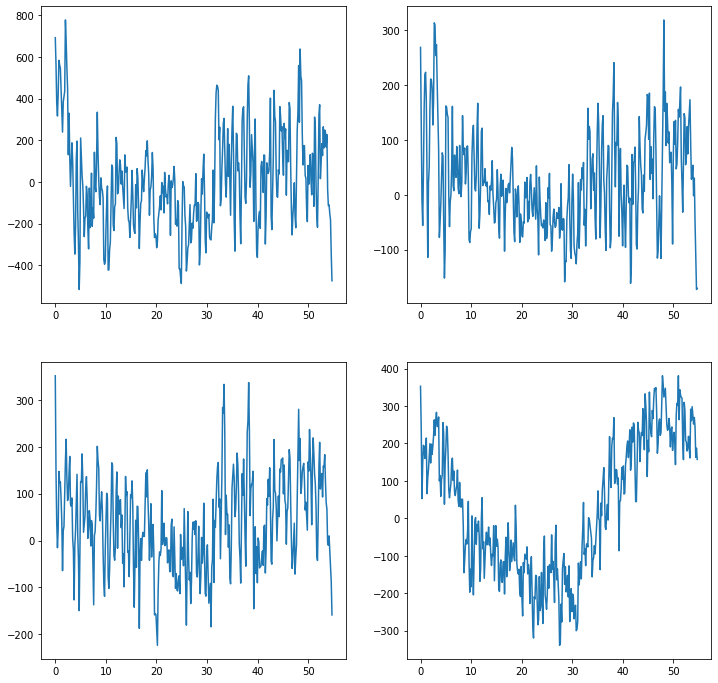

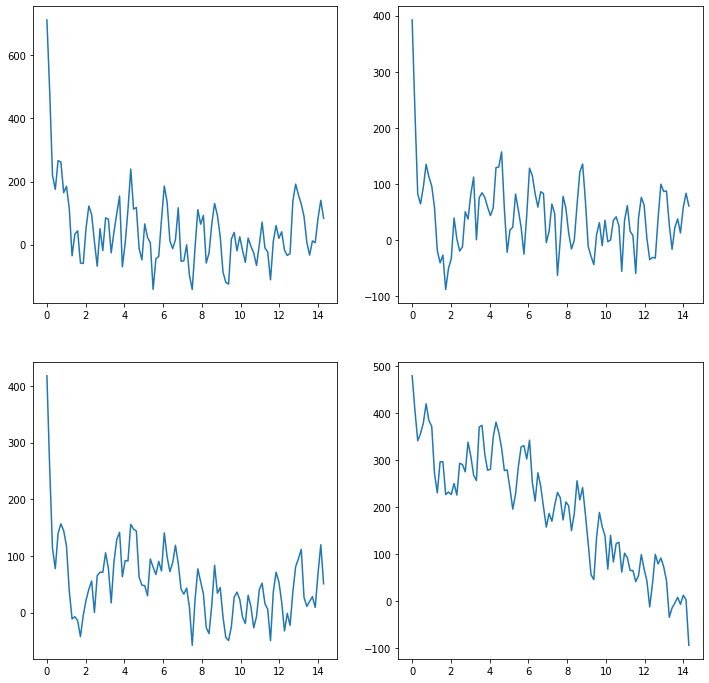

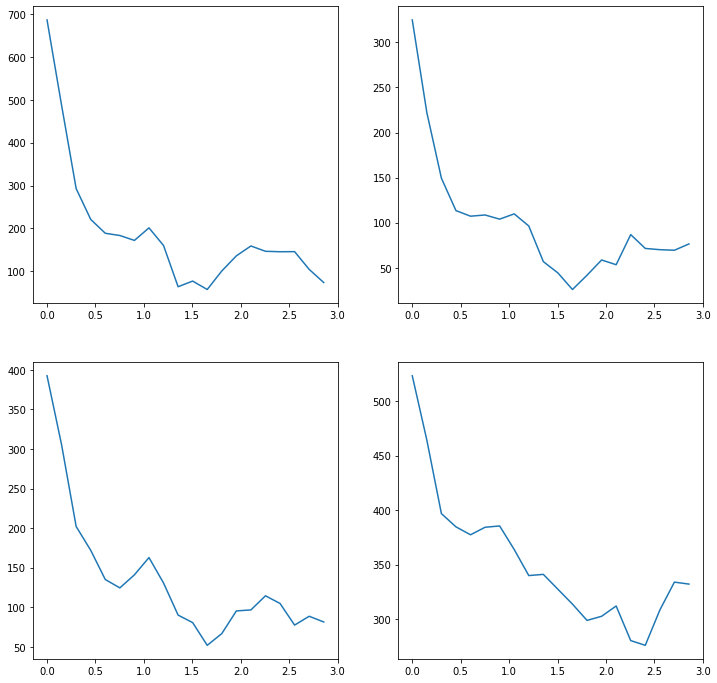

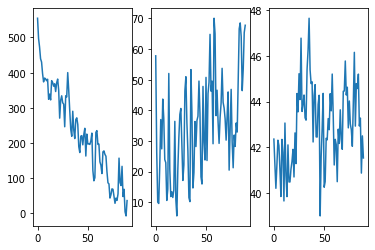

In [48]:
import matplotlib.pyplot as plt
from scipy.fft import fft

def convolucionDiscreta(datos):
  '''
  Dada una serie temporal 1D, calcula su convolucion siendo ademas argumento de salida
  '''
  conv = []
  promediados = []
  longitudDatos = len(datos)
  for distanciaCorr in range(len(datos)):
    realizacionesParaPromediar = len(datos) - distanciaCorr # Numero de veces que podemos convulocionar el array sobre si mismo
    promediados.append(realizacionesParaPromediar)
    conv.append(0.)
    for muestra in range(realizacionesParaPromediar):
       conv[distanciaCorr] += datos[muestra]*datos[muestra + distanciaCorr]
       
    conv[distanciaCorr] = conv[distanciaCorr]/float(realizacionesParaPromediar)

  return np.asarray(correlacion), promediados

def averCorrCompt(serie,longitudProceso):
  '''
  Interpreta la serie temporal como un proceso estocástico estacionario en el cual podemos samplear muestras que 
  poseen las mismas propiedades estacionarias y asi analizar la correlacion de su ruido
  '''

  # Intentar el particionado de la serie temporal en subprocesos que evolucionan sobre un intervalo longitudProceso
  particiones = len(serie) // longitudProceso
  if particiones < 10:
    raise NameError("Son menos de 10 realizaciones para promediar")
  else:
    # Al ser un numpy array, debe ser necesario dividirse en partes iguales
    serie_p = serie[0:particiones*longitudProceso]
  particionado = np.split(serie_p,particiones)

  # Es una matriz
  correlacion = np.zeros([longitudProceso,longitudProceso])

  # Necesitamos derivar la media previamente
  media = np.zeros(longitudProceso)
  media = (1./float(particiones))*np.sum(particionado, axis=0)

  for i in range(longitudProceso): 
    for j in range(i,longitudProceso,1):
      # Promediado
      for k in range(particiones):
        correlacion[i,j] += (particionado[k][i]-media[i])*(particionado[k][j]-media[j])
      # Esta matriz es simétrica
      correlacion[j,i] = correlacion[i,j]

  # Normalizado de la matriz
  correlacion = correlacion*(1./float(particiones))
  return np.asarray(correlacion), np.asarray(media)





def frecuenciasInternas(datos,dx):
  '''
  Dada una serie de datos devuelve el espectro de frecuencias que lo compone y el dominio espectral correspondiente
  dx la unidad minima en la que el dominio esta particionado
  '''
  datosf = fft(datos)


  x = np.linspace(0.0, len(datos)*dx, len(datos))
  xf = np.linspace(0.0, (2*np.pi)/(len(datos)*dx), len(datos)//2)

  s_datosf_sq = np.real((2./len(datos))*np.sqrt(np.multiply(datosf,np.conj(datosf)))[0:len(datos)//2])

  return s_datosf_sq, xf

################

grid_plots_datos_10, [(ax11a,ax12a),(ax21a,ax22a)] = plt.subplots(2,2,figsize=(12,12))
grid_plots_datos_38, [(ax11b,ax12b),(ax21b,ax22b)] = plt.subplots(2,2,figsize=(12,12))
grid_plots_datos_190, [(ax11c,ax12c),(ax21c,ax22c)] = plt.subplots(2,2,figsize=(12,12))

est56NO2_np = est56NO2_df.to_numpy()
est24NO2_np = est24NO2_df.to_numpy()
est03NO2_np = est03NO2_df.to_numpy()
est03O3_np = est03O3_df.to_numpy()


longitudDatos = len(est56NO2_np)

dx = (1./7) # Vamos a presentar en semanas la correlacion

r10 = np.linspace(0,longitudDatos//10*dx,longitudDatos//10)
r38 = np.linspace(0,longitudDatos//38*dx,longitudDatos//38)
r190 = np.linspace(0,longitudDatos//190*dx,longitudDatos//190)

####

correlacion56, parapromediar56 = averCorrCompt(est56NO2_np[:,0],longitudDatos//10)
correlacion24, parapromediar24 = averCorrCompt(est24NO2_np[:,0],longitudDatos//10)
correlacion03NO2, parapromediar03NO2 = averCorrCompt(est03NO2_np[:,0],longitudDatos//10)
correlacion03O3, parapromediar03O3 = averCorrCompt(est03O3_np[:,0],longitudDatos//10)

ax11a.plot(r10,correlacion56[0,:])
 
ax12a.plot(r10,correlacion24[0,:])
 
ax21a.plot(r10,correlacion03NO2[0,:])
    
ax22a.plot(r10,correlacion03O3[0,:])


grid_plots_datos_10.show()

####

correlacion56, parapromediar56 = averCorrCompt(est56NO2_np[:,0],longitudDatos//38)
correlacion24, parapromediar24 = averCorrCompt(est24NO2_np[:,0],longitudDatos//38)
correlacion03NO2, parapromediar03NO2 = averCorrCompt(est03NO2_np[:,0],longitudDatos//38)
correlacion03O3, parapromediar03O3 = averCorrCompt(est03O3_np[:,0],longitudDatos//38)

ax11b.plot(r38,correlacion56[0,:])
 
ax12b.plot(r38,correlacion24[0,:])
 
ax21b.plot(r38,correlacion03NO2[0,:])
    
ax22b.plot(r38,correlacion03O3[0,:])


grid_plots_datos_38.show()

####

correlacion56, parapromediar56 = averCorrCompt(est56NO2_np[:,0],longitudDatos//190)
correlacion24, parapromediar24 = averCorrCompt(est24NO2_np[:,0],longitudDatos//190)
correlacion03NO2, parapromediar03NO2 = averCorrCompt(est03NO2_np[:,0],longitudDatos//190)
correlacion03O3, parapromediar03O3 = averCorrCompt(est03O3_np[:,0],longitudDatos//190)

ax11c.plot(r190,correlacion56[0,:])
 
ax12c.plot(r190,correlacion24[0,:])
 
ax21c.plot(r190,correlacion03NO2[0,:])
    
ax22c.plot(r190,correlacion03O3[0,:])


grid_plots_datos_190.show()




x = np.arange(len(correlacion))
x = x*(1./365.)

acab = np.asarray(list(zip(x,correlacion)))

resultados = np.where(acab[:,0]<periodos[frecuenciaMaxima])
print(resultados[0])

#resultados = [np.array(zipped[0],zipped[1]) for zipped[0] < periodos[frecuenciaMaxima] in list(zip(x,correlacion))]

ax_cor_p.plot(acab[resultados[0],0],acab[resultados[0],1])

#fig.show()


#figf.show()

#fig_cor_p.show()

covMatrix, aver = averCorrCompt(datos[:,0],90)


aaa,(bbb1,bbb2,bbb3) = plt.subplots(1,3)
linea = covMatrix[0,:]
bbb1.plot(linea)
bbb2.plot(datos[:90,0])
bbb3.plot(aver)
aaa.show()

#plt.imshow(covMatrix)




Correlacion entre un punto y j : 0  siguientes
Correlacion entre un punto y j : 1  siguientes
Correlacion entre un punto y j : 2  siguientes
Correlacion entre un punto y j : 3  siguientes
Correlacion entre un punto y j : 4  siguientes
Correlacion entre un punto y j : 5  siguientes
Correlacion entre un punto y j : 6  siguientes
Correlacion entre un punto y j : 7  siguientes
Correlacion entre un punto y j : 8  siguientes
Correlacion entre un punto y j : 9  siguientes
Correlacion entre un punto y j : 10  siguientes
Correlacion entre un punto y j : 11  siguientes
Correlacion entre un punto y j : 12  siguientes
Correlacion entre un punto y j : 13  siguientes
Correlacion entre un punto y j : 14  siguientes
Correlacion entre un punto y j : 15  siguientes
Correlacion entre un punto y j : 16  siguientes
Correlacion entre un punto y j : 17  siguientes
Correlacion entre un punto y j : 18  siguientes
Correlacion entre un punto y j : 19  siguientes
Correlacion entre un punto y j : 20  siguientes
Co

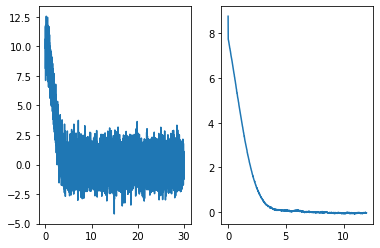

In [ ]:
import random

# Un ejemplo de juguete para ver si tiene sentido lo que estoy pensando
x = np.linspace(0,30,10000)
Sruido = 1.
ruido = Sruido*np.fromiter([random.gauss(0.0, 1.0) for i in range(10000)],float)
l = 5.
A = 10.
datos = A*np.exp(-np.power(x,2)/l) + ruido

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(x,datos)

correlacion = np.zeros(1000)
x_corr = np.zeros(1000)
f = 4
inc = 0
for j in range(1000):
  x_corr[j] = x[inc]
  print("Correlacion entre un punto y j :",j," siguientes")
  for i in range(10000-4000):
    correlacion[j] += datos[i]*datos[i+inc]
  correlacion[j] = correlacion[j]/(10000-4000)
  inc = inc + f

ax2.plot(x_corr,correlacion)

fig.show()


He probado a partir de la premisa que los datos corresponden a un proceso estocástico estacionario sobre el que calcular correlaciones para estimar cuantos puntos son suficientes para ser incorporados al entrenamiento de un proceso gaussiano. 

La realidad es que la correlacion nunca tiende estacionariamente a cero con los datos proporcionados (intentando que promediemos siempre sobre 20 realizaciones como minimo del proceso estocastico que conforma la serie temporal). He asumido que partiendo la serie temporal en trozos independientes estamos "sampleando" el proceso estocastico sobre el que obtenemos estas correlaciones.

Pues las correlaciones nunca tienden a cero, bien se hacen negativas y no somos capaces de calcular correlaciones a tiempos mas largos. El promedio del proceso estocastico es posible de computar pero son muy fluctuantes.

En el mejor de los casos me faltan datos para extraer la informacion que deseo de los datos y el hecho de que el proceso no tiende a una media constante pues implica que no es estacionario y no podemos hacer esta aproximación.

Creo que he confundido ciertos conceptos pero para esta serie temporal que modula no podemos presuponer un "conjunto de datos sobre que la memoria del proceso es cero si realizamos mas alla".

Proceso de Ornstein–Uhlenbeck

Voy a generar un proceso de esta naturaleza resolviendo la ec. diferencial estocástica pertinente y vamos a calcular su matriz de covarianza y vamos
a compararlo con la proveniente del kernel que hace que un proceso gausiano genere este tipo de trayectorias

Calculamos muestra
Calculamos correlaciones


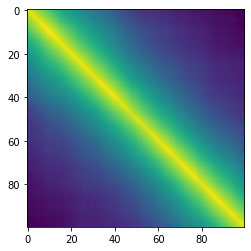

In [ ]:
import pandas as pd


def procesoOU(n,dt,tau):
  '''
  Genera un proceso OU
  n es la longitud del proceso estocástico
  dt es el paso temporal
  tau es la escala caracteríística de tiempos del proceso
  '''

  def relacionRecursiva(i,dt,tau,xiou):
    '''
    Esta funcion es para calcular de forma recursiva los diferentes terminos del proceso OU en el que la amplitud de la covarianza es la unidad 
    independientemente de la escala temporal
    '''
    if i == 0:
      xiou[0] = random.gauss(0,1) 
    else:
      xiou[i] = xiou[i-1]*np.exp(-dt/tau)+np.sqrt(1-np.exp(-(2*dt)/tau))*random.gauss(0,1)

    return xiou[i]

  xiou = np.zeros(n)

  realizacionOU = np.asarray([ relacionRecursiva(i,dt,tau,xiou) for i in range(n)])

  return realizacionOU

def matrizCov(muestra,longitudProceso,realizaciones):
  '''
  La muestra es un iterable o lista con un numero determinado de muestras del proceso sobre el que calcular correlaciones
  '''

  # Es una matriz
  correlacion = np.zeros([longitudProceso,longitudProceso])

  # Necesitamos derivar la media previamente
  media = np.zeros(longitudProceso)
  media = (1./float(realizaciones))*np.sum(muestra, axis=0)

  # Promediando
  for k in range(realizaciones):
    vectorfila = np.array([muestra[k]-media])
    productosCovariantes = np.matmul(vectorfila.T,vectorfila)
    correlacion += productosCovariantes # Es una suma de matrices

  # Normalizado de la matriz
  correlacion = correlacion*(1./float(realizaciones))
  return np.asarray(correlacion), np.asarray(media)




n = 4000 # realizacones
m = 100 # longitud Proceso
dt = 0.2 # paso temporal
tau = 7. # Escala temporal del proceso


x = np.linspace(0,m*dt,m) # dominio del proceso

print("Calculamos muestra")
muestra = [procesoOU(m,dt,tau) for i in range(n)]

print("Calculamos correlaciones")
corr, media = matrizCov(muestra,m,n)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11.3,7))

ax2.plot(x,corr[0,:], label='Calculo computacional')
#ax2.plot(x,media)
#ax2.plot(x,(1./(2*tau))*np.exp(-x/tau), label='Resultado teorico')
ax2.plot(x,np.exp(-x/tau), label='Resultado teorico')

[ax1.plot(x,muestra[i][:]) for i in range(10)]

sigma = np.asarray([np.sqrt(corr[i,i]) for i in range(m)])


data_set = {}
index = []
for i  in range(m):
  data_set['x'+str(i)] = corr[i,:]

for j in range(m):
  index.append("x"+str(j))

corr_csv = pd.DataFrame(data_set,index)
corr_csv.to_csv('K_OU_experimental.csv')



ax1.plot(x,media)
ax1.plot(x,sigma,'r--')
ax1.plot(x,1.98*sigma,'b--')
ax1.plot(x,-sigma,'r--')
ax1.plot(x,-1.98*sigma,'b--')
ax1.set_xlabel('Input / x')
ax2.set_xlabel('Distancia / r')
ax1.set_ylabel('Proceso / $\eta ( x ) $')
ax2.set_ylabel('Correlacion  / $ < \eta  ( x ) \eta ( x \' )> $')
ax2.legend(loc='upper center').get_frame().set_facecolor('C0')



fig.show()